# Loading datasets from database

In [4]:
!python3 -m pip install --upgrade 'sqlalchemy < 2.0'

In [1]:
import pandas as pd
import sqlalchemy

print(pd.__version__)
print(sqlalchemy.__version__)

1.3.5
1.4.54


In [3]:
import os
import pandas as pd
from sqlalchemy import create_engine
from dotenv import load_dotenv

load_dotenv()

DB_URL = os.getenv("DB_URL")

if not DB_URL:
    raise ValueError("Database URL not found. Make sure you have a .env file or set the environment variable.")


user_data = pd.read_sql(
    """SELECT * FROM public.user_data""",
    con=DB_URL
)

user_data

,user_id,gender,age,country,city,exp_group,os,source
0,200,1,34,Russia,Degtyarsk,3,Android,ads
1,201,0,37,Russia,Abakan,0,Android,ads
2,202,1,17,Russia,Smolensk,4,Android,ads
3,203,0,18,Russia,Moscow,1,iOS,ads
4,204,0,36,Russia,Anzhero-Sudzhensk,3,Android,ads
...,...,...,...,...,...,...,...,...
163200,168548,0,36,Russia,Kaliningrad,4,Android,organic
163201,168549,0,18,Russia,Tula,2,Android,organic
163202,168550,1,41,Russia,Yekaterinburg,4,Android,organic
163203,168551,0,38,Russia,Moscow,3,iOS,organic


In [5]:
post_text_df = pd.read_sql(
    """SELECT * FROM public.post_text_df""",
    con=DB_URL
)

post_text_df

,post_id,text,topic
0,1,UK economy facing major risks\n\nThe UK manufa...,business
1,2,Aids and climate top Davos agenda\n\nClimate c...,business
2,3,Asian quake hits European shares\n\nShares in ...,business
3,4,India power shares jump on debut\n\nShares in ...,business
4,5,Lacroix label bought by US firm\n\nLuxury good...,business
...,...,...,...
7018,7315,"OK, I would not normally watch a Farrelly brot...",movie
7019,7316,I give this movie 2 stars purely because of it...,movie
7020,7317,I cant believe this film was allowed to be mad...,movie
7021,7318,The version I saw of this film was the Blockbu...,movie


In [7]:
feed_data = pd.read_sql(
    """SELECT * FROM public.feed_data 
        limit 5000000
    """,
    con=DB_URL
)

feed_data

,timestamp,user_id,post_id,action,target
0,2021-11-09 21:08:39,128462,3439,view,0
1,2021-11-09 21:10:34,128462,3141,view,0
2,2021-11-09 21:12:39,128462,3893,view,0
3,2021-11-09 21:14:14,128462,169,view,0
4,2021-11-09 21:16:44,128462,5797,view,0
...,...,...,...,...,...
4999995,2021-11-09 07:10:52,8014,1719,view,0
4999996,2021-11-09 07:12:34,8014,1140,view,0
4999997,2021-11-09 07:15:23,8014,1373,view,0
4999998,2021-11-09 07:15:45,8014,1730,view,0


In [9]:
### checking balance of classes in target

feed_data['target'].value_counts()

0    4464166
1     535834
Name: target, dtype: int64

# Analysing column "text" in post_text_df

In [12]:
print(post_text_df.loc[67, 'text'])

High fuel costs hit US airlines

Two of the largest airlines in the US - American and Southwest - have blamed record fuel prices for their disappointing quarterly results.

American Airlines parent AMR reported a loss of $387m (£206m) for the fourth quarter of 2004, against a $111m loss for the same period a year earlier. Meanwhile, Southwest Airlines saw its fourth-quarter 2004 profits fall 15% to $56m, against $66m a year earlier. Both said high fuel bills would continue to pressure revenues in 2005. American, the worlds biggest airline by some measures, said it expected to report a loss for the first quarter of 2005. Southwest, which has the highest market value of any US carrier, said it would remain profitable despite high fuel prices.

AMRs shares were flat in Wednesday morning trading on the New York Stock Exchange, as the results were slightly better than analysts had anticipated. AMRs chief executive Gerard Arpey said the airlines difficulties reflected the situation within th

In [14]:
print(post_text_df.loc[876, 'text'])

.@AITCofficial MLA Samaresh Das passes away due to #COVID19

https://t.co/JOJdheLSM5


In [16]:
print(post_text_df.loc[5000, 'text'])

Truly a great film... I stumbled onto it at the video store and rented it because Aaron Eckhart (In the Company of Men and Your Friends and Neighbors) was in it as well as Paulina Porizcova... The lovely former SI swimsuit model does get nude in the film, but that is only one of the many reasons to rent it... Its very exciting, and the character development is fantastic... Eckhart is one of the most underrated actors working, and he steals this film... It is very dark and violent, but I enjoyed in immensely....


In [18]:
### by seeing some of the posts, I think it makes sense to extract couple of features:
### 1) length of post
### 2) number of hashtags
### 3) number of mentions @
### 4) if has a hashtag
### 5) if has an http url

In [20]:
post_text_df['post_length'] = post_text_df['text'].apply(len)

In [22]:
post_text_df['num_hashtags'] = post_text_df['text'].apply(lambda x: x.count('#'))

In [24]:
post_text_df['num_mentions'] = post_text_df['text'].apply(lambda x: x.count('@'))

In [26]:
post_text_df['has_hashtag'] = post_text_df['text'].apply(lambda x: '#' in x)

In [28]:
post_text_df['has_url'] = post_text_df['text'].apply(lambda x: 'http' in x)

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(
    stop_words='english')

tfidf_matrix = tfidf_vectorizer.fit_transform(post_text_df['text'])

In [30]:
post_text_df = post_text_df.drop('text', axis=1)

# Merging datasets

In [33]:
df = pd.merge(
    feed_data,
    user_data,
    on='user_id',
    how='left'
)

df.head()

,timestamp,user_id,post_id,action,target,gender,age,country,city,exp_group,os,source
0,2021-11-09 21:08:39,128462,3439,view,0,0,22,Russia,Vyaz’ma-Bryanskaya,1,Android,organic
1,2021-11-09 21:10:34,128462,3141,view,0,0,22,Russia,Vyaz’ma-Bryanskaya,1,Android,organic
2,2021-11-09 21:12:39,128462,3893,view,0,0,22,Russia,Vyaz’ma-Bryanskaya,1,Android,organic
3,2021-11-09 21:14:14,128462,169,view,0,0,22,Russia,Vyaz’ma-Bryanskaya,1,Android,organic
4,2021-11-09 21:16:44,128462,5797,view,0,0,22,Russia,Vyaz’ma-Bryanskaya,1,Android,organic


In [35]:
data = pd.merge(
    df,
    post_text_df,
    on='post_id',
    how='left'
)
data

,timestamp,user_id,post_id,action,target,gender,age,country,city,exp_group,os,source,topic,post_length,num_hashtags,num_mentions,has_hashtag,has_url
0,2021-11-09 21:08:39,128462,3439,view,0,0,22,Russia,Vyaz’ma-Bryanskaya,1,Android,organic,covid,131,3,1,True,True
1,2021-11-09 21:10:34,128462,3141,view,0,0,22,Russia,Vyaz’ma-Bryanskaya,1,Android,organic,covid,140,6,0,True,True
2,2021-11-09 21:12:39,128462,3893,view,0,0,22,Russia,Vyaz’ma-Bryanskaya,1,Android,organic,covid,89,2,1,True,False
3,2021-11-09 21:14:14,128462,169,view,0,0,22,Russia,Vyaz’ma-Bryanskaya,1,Android,organic,business,1372,0,0,False,False
4,2021-11-09 21:16:44,128462,5797,view,0,0,22,Russia,Vyaz’ma-Bryanskaya,1,Android,organic,movie,632,0,0,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4999995,2021-11-09 07:10:52,8014,1719,view,0,0,22,Ukraine,Ivano-Frankivsk,0,Android,ads,sport,3616,0,0,False,False
4999996,2021-11-09 07:12:34,8014,1140,view,0,0,22,Ukraine,Ivano-Frankivsk,0,Android,ads,politics,3231,0,0,False,False
4999997,2021-11-09 07:15:23,8014,1373,view,0,0,22,Ukraine,Ivano-Frankivsk,0,Android,ads,politics,1631,0,0,False,False
4999998,2021-11-09 07:15:45,8014,1730,view,0,0,22,Ukraine,Ivano-Frankivsk,0,Android,ads,sport,987,0,0,False,False


# Analysing numeric and categorical columns

In [38]:
### checking numeric columns
import numpy as np

numeric_columns = data.loc[:,data.dtypes!=np.object_].columns
data.loc[:,data.dtypes!=np.object_].head(2)

,timestamp,user_id,post_id,target,gender,age,exp_group,post_length,num_hashtags,num_mentions,has_hashtag,has_url
0,2021-11-09 21:08:39,128462,3439,0,0,22,1,131,3,1,True,True
1,2021-11-09 21:10:34,128462,3141,0,0,22,1,140,6,0,True,True


In [40]:
### checking categorical columns

categorical_columns = data.loc[:,data.dtypes==np.object_].columns
data.loc[:,data.dtypes==np.object_].head(2)

,action,country,city,os,source,topic
0,view,Russia,Vyaz’ma-Bryanskaya,Android,organic,covid
1,view,Russia,Vyaz’ma-Bryanskaya,Android,organic,covid


In [41]:
### target should eventually be removed from numeric columns

In [44]:
### gender, exp_group, has_hashtag, has_url are also categorical columns

In [46]:
### moving gender, exp_group, has_hashtag, has_url to categorical columns

categorical_as_object = ['gender', 'exp_group', 'has_hashtag', 'has_url', ] 

data[categorical_as_object] = data[categorical_as_object].astype('object')

In [47]:
### checking categorical columns

categorical_columns = data.loc[:,data.dtypes==np.object_].columns
data.loc[:,data.dtypes==np.object_].head(2)

,action,gender,country,city,exp_group,os,source,topic,has_hashtag,has_url
0,view,0,Russia,Vyaz’ma-Bryanskaya,1,Android,organic,covid,True,True
1,view,0,Russia,Vyaz’ma-Bryanskaya,1,Android,organic,covid,True,True


In [49]:
### checking numeric columns

numeric_columns = data.loc[:,data.dtypes!=np.object_].columns
data.loc[:,data.dtypes!=np.object_].head(2)

,timestamp,user_id,post_id,target,age,post_length,num_hashtags,num_mentions
0,2021-11-09 21:08:39,128462,3439,0,22,131,3,1
1,2021-11-09 21:10:34,128462,3141,0,22,140,6,0


In [52]:
### correlation between numeric features

data[numeric_columns].corr()

,user_id,post_id,target,age,post_length,num_hashtags,num_mentions
user_id,1.000000,-0.000808,-0.001598,0.007076,-0.000543,0.000638,0.000160
post_id,-0.000808,1.000000,0.002404,-0.022679,-0.277439,-0.024394,-0.008040
target,-0.001598,0.002404,1.000000,0.000154,-0.002577,-0.003373,-0.000489
age,0.007076,-0.022679,0.000154,1.000000,0.007270,0.009443,0.003284
post_length,-0.000543,-0.277439,-0.002577,0.007270,1.000000,-0.317187,-0.194088
num_hashtags,0.000638,-0.024394,-0.003373,0.009443,-0.317187,1.000000,0.122096
num_mentions,0.000160,-0.008040,-0.000489,0.003284,-0.194088,0.122096,1.000000


<Axes: >

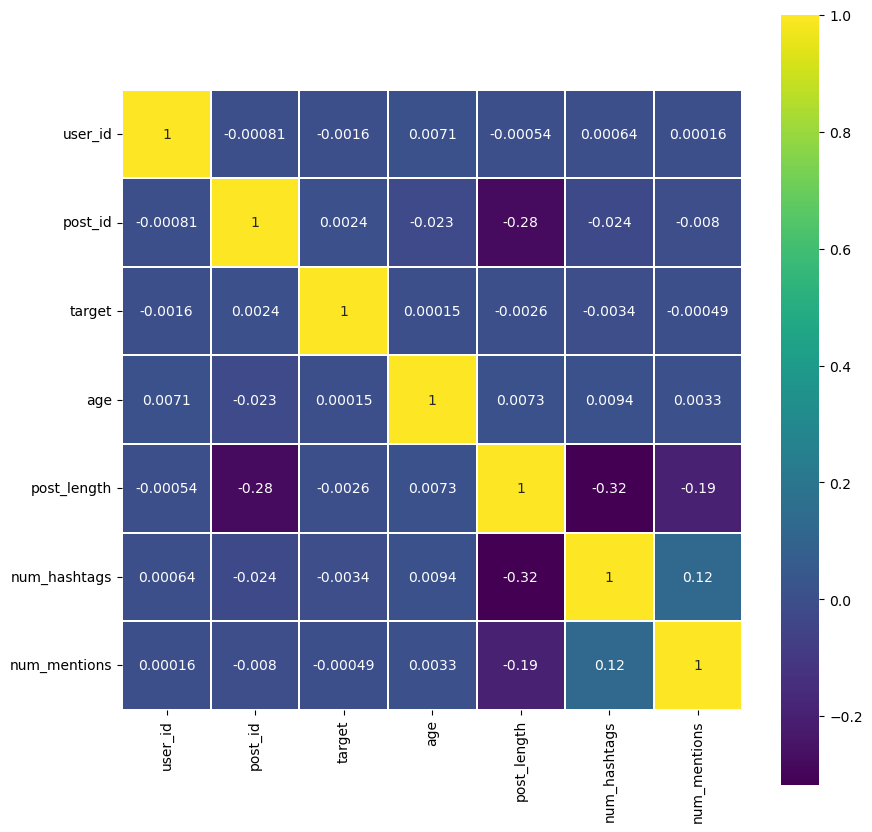

In [54]:
### correlation matrix
import matplotlib.pyplot as plt
import seaborn as sns

colormap = plt.cm.viridis
plt.figure(figsize=(10,10))
sns.heatmap(data.corr(), linewidths=0.1, vmax=1.0, square=True, cmap=colormap, annot=True)

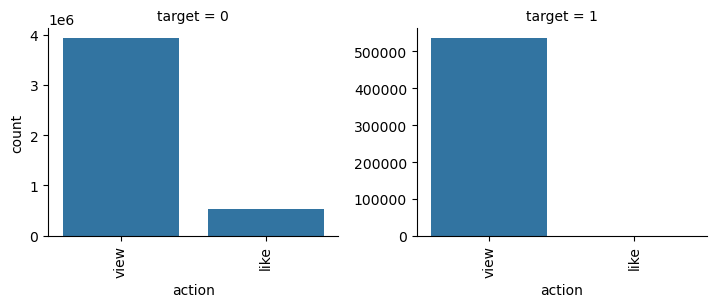

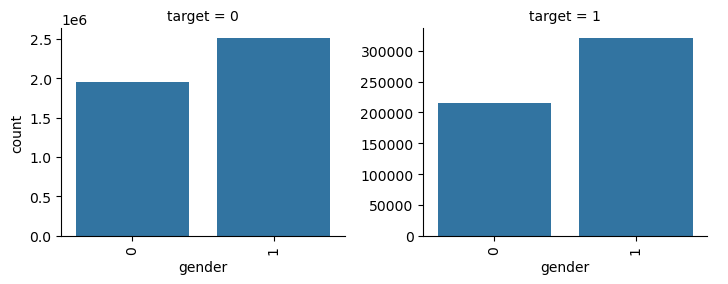

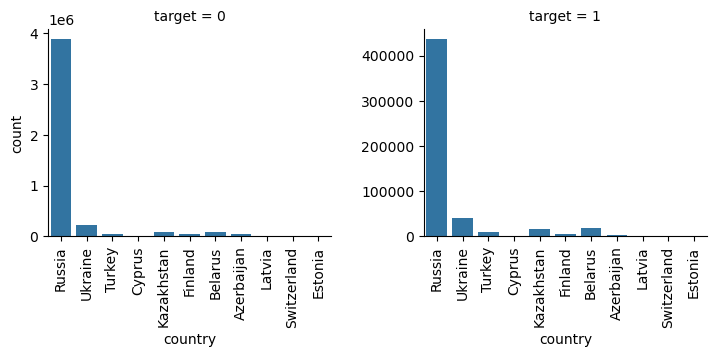

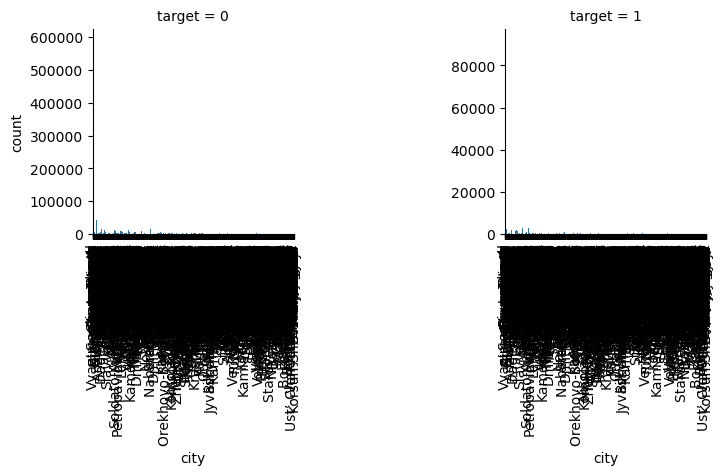

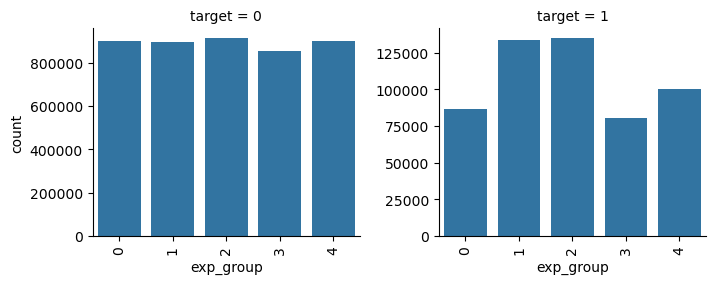

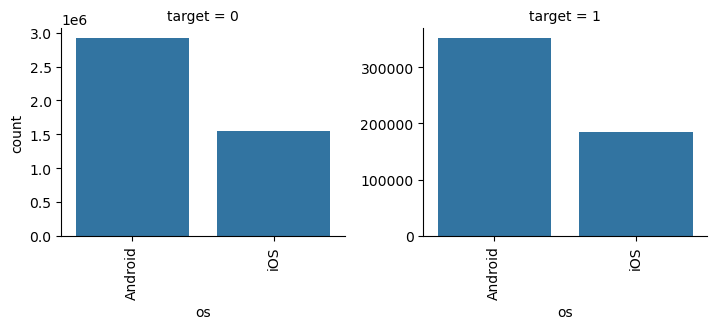

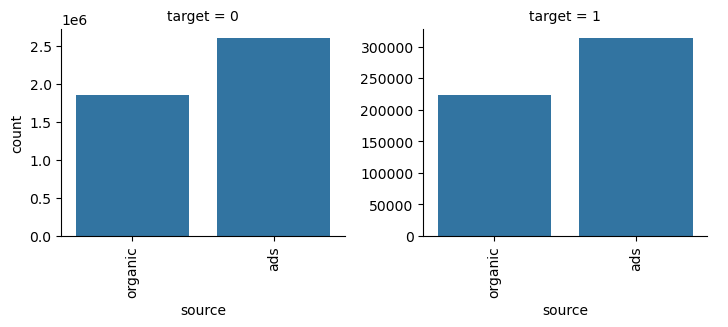

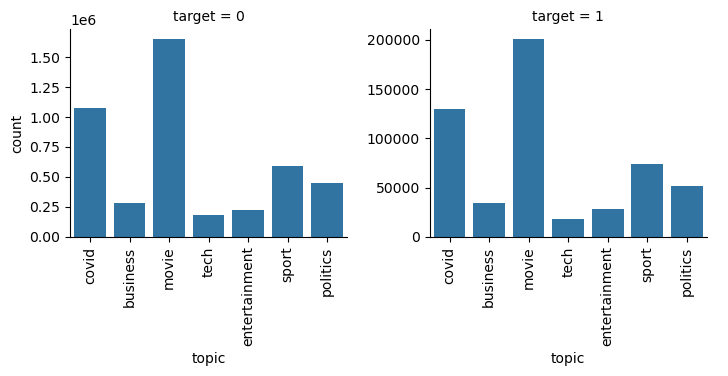

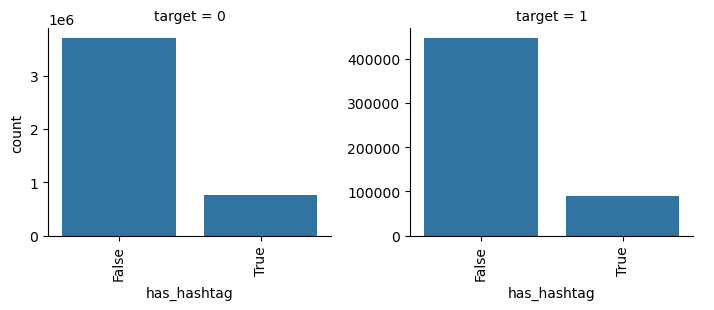

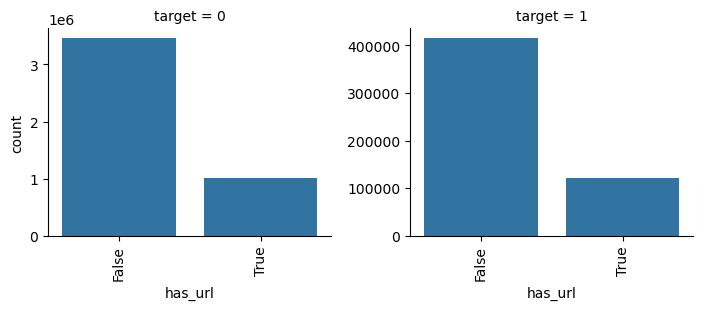

In [56]:
### Histograms of distribution between classes

for col in categorical_columns:
    g = sns.catplot(x=col, kind='count', col='target', data=data, sharey=False, height=3, aspect=1.2)
    g.set_xticklabels(rotation=90)

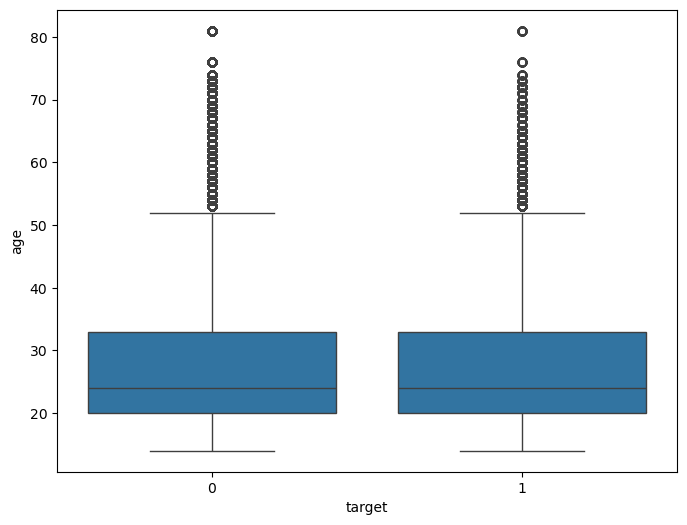

In [57]:
### distribution of age vs target

fig = plt.figure()
fig.set_size_inches(8,6)
sns.boxplot(y=data['age'], x=data['target'].astype('category'), data = data)
plt.show()

In [58]:
### check nans

data.isna().sum()

timestamp       0
user_id         0
post_id         0
action          0
target          0
gender          0
age             0
country         0
city            0
exp_group       0
os              0
source          0
topic           0
post_length     0
num_hashtags    0
num_mentions    0
has_hashtag     0
has_url         0
dtype: int64

In [59]:
data

,timestamp,user_id,post_id,action,target,gender,age,country,city,exp_group,os,source,topic,post_length,num_hashtags,num_mentions,has_hashtag,has_url
0,2021-11-09 21:08:39,128462,3439,view,0,0,22,Russia,Vyaz’ma-Bryanskaya,1,Android,organic,covid,131,3,1,True,True
1,2021-11-09 21:10:34,128462,3141,view,0,0,22,Russia,Vyaz’ma-Bryanskaya,1,Android,organic,covid,140,6,0,True,True
2,2021-11-09 21:12:39,128462,3893,view,0,0,22,Russia,Vyaz’ma-Bryanskaya,1,Android,organic,covid,89,2,1,True,False
3,2021-11-09 21:14:14,128462,169,view,0,0,22,Russia,Vyaz’ma-Bryanskaya,1,Android,organic,business,1372,0,0,False,False
4,2021-11-09 21:16:44,128462,5797,view,0,0,22,Russia,Vyaz’ma-Bryanskaya,1,Android,organic,movie,632,0,0,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4999995,2021-11-09 07:10:52,8014,1719,view,0,0,22,Ukraine,Ivano-Frankivsk,0,Android,ads,sport,3616,0,0,False,False
4999996,2021-11-09 07:12:34,8014,1140,view,0,0,22,Ukraine,Ivano-Frankivsk,0,Android,ads,politics,3231,0,0,False,False
4999997,2021-11-09 07:15:23,8014,1373,view,0,0,22,Ukraine,Ivano-Frankivsk,0,Android,ads,politics,1631,0,0,False,False
4999998,2021-11-09 07:15:45,8014,1730,view,0,0,22,Ukraine,Ivano-Frankivsk,0,Android,ads,sport,987,0,0,False,False


# Train and test sample

In [65]:
sorted_data = data.sort_values('timestamp')

In [67]:
sorted_data = sorted_data.drop(['action', 'timestamp', 'post_id', 'user_id'], axis=1)

In [69]:
train = sorted_data.iloc[:-100000].copy() 
test = sorted_data.iloc[-100000:].copy() 

In [71]:
train

,target,gender,age,country,city,exp_group,os,source,topic,post_length,num_hashtags,num_mentions,has_hashtag,has_url
3126078,1,0,30,Kazakhstan,Mangghystaū,3,iOS,organic,movie,3765,0,0,False,False
3786131,1,1,15,Russia,Mikhaylovka,4,Android,ads,covid,137,0,0,False,True
1361122,0,1,28,Russia,Chelyabinsk,4,iOS,organic,movie,722,0,0,False,False
3831169,1,0,24,Russia,Moscow,3,iOS,organic,politics,955,0,0,False,False
4204006,1,0,25,Russia,Vladivostok,4,Android,ads,covid,140,5,0,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3451624,0,1,22,Ukraine,Dnipro,4,Android,ads,politics,1450,0,0,False,False
3060198,0,0,18,Russia,Zelënodol’sk,4,Android,ads,covid,137,2,0,True,False
1414001,0,1,41,Russia,Fryazino,4,Android,organic,covid,140,0,1,False,True
2494316,0,1,36,Russia,Moscow,1,Android,organic,sport,1130,0,0,False,False


In [73]:
test

,target,gender,age,country,city,exp_group,os,source,topic,post_length,num_hashtags,num_mentions,has_hashtag,has_url
2016401,0,0,20,Russia,Moscow,4,Android,ads,covid,138,0,1,False,True
4482851,0,0,18,Russia,Armavir,1,Android,ads,business,1007,0,0,False,False
3931866,0,0,26,Russia,Saratov,0,iOS,ads,sport,1073,0,0,False,False
221752,0,0,26,Russia,Cheboksary,4,iOS,ads,movie,1996,0,0,False,False
2372299,0,1,20,Russia,Ryazan,4,Android,ads,movie,693,0,0,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
645659,0,0,20,Ukraine,Tiachiv,0,Android,ads,movie,1330,0,0,False,False
2553988,0,1,24,Kazakhstan,Petropavl,4,iOS,ads,movie,4192,0,0,False,False
625184,0,1,39,Russia,Novomoskovsk,4,Android,organic,movie,690,0,0,False,False
645660,0,0,20,Ukraine,Tiachiv,0,Android,ads,tech,3923,0,0,False,False


In [75]:
### Seperating data on features and target

X_train = train.drop('target', axis=1)
X_test = test.drop('target', axis=1)

y_train = train['target']
y_test = test['target']

# Transformer for categorical and numeric columns

In [78]:
categorical_columns

Index(['action', 'gender', 'country', 'city', 'exp_group', 'os', 'source',
       'topic', 'has_hashtag', 'has_url'],
      dtype='object')

In [80]:
categorical_columns = categorical_columns.difference(['action'])

In [82]:
categorical_columns

Index(['city', 'country', 'exp_group', 'gender', 'has_hashtag', 'has_url',
       'os', 'source', 'topic'],
      dtype='object')

In [84]:
numeric_columns

Index(['timestamp', 'user_id', 'post_id', 'target', 'age', 'post_length',
       'num_hashtags', 'num_mentions'],
      dtype='object')

In [86]:
list(X_train.select_dtypes(include=['float64', 'int64']).columns)

['age', 'post_length', 'num_hashtags', 'num_mentions']

In [88]:
numeric_cols = list(X_train.select_dtypes(include=['float64', 'int64']).columns)

print(numeric_cols)

['age', 'post_length', 'num_hashtags', 'num_mentions']


In [90]:
### creating transformer for categorical features

from sklearn.compose import ColumnTransformer
from category_encoders import TargetEncoder
from category_encoders.one_hot import OneHotEncoder
from sklearn.preprocessing import StandardScaler

### Your code is here

### saving the cols for OHE, mean target encoders, numeric cols

cols_for_ohe = [x for x in categorical_columns if X_train[x].nunique() < 5]
cols_for_mte = [x for x in categorical_columns if X_train[x].nunique() >= 5]

### saving indeces of these cols

cols_for_ohe_idx = [list(X_train.columns).index(col) for col in cols_for_ohe]
cols_for_mte_idx = [list(X_train.columns).index(col) for col in cols_for_mte]
numeric_cols_idx = [list(X_train.columns).index(col) for col in numeric_cols]

In [92]:
t = [('OneHotEncoder', OneHotEncoder(), cols_for_ohe_idx), ### indices are added here. best to add as list of indices. not the names of cols
     ('MeanTargetEncoder', TargetEncoder(), cols_for_mte_idx),
     ('StandardScaler', StandardScaler(), numeric_cols_idx)]

col_transform = ColumnTransformer(transformers=t)

In [94]:
np.random.seed(1)

col_transform.fit(X_train, y_train)

ColumnTransformer(transformers=[('OneHotEncoder', OneHotEncoder(),
                                 [0, 11, 12, 5, 6]),
                                ('MeanTargetEncoder', TargetEncoder(),
                                 [3, 2, 4, 7]),
                                ('StandardScaler', StandardScaler(),
                                 [1, 8, 9, 10])])

# Decision Tree with default parameters

In [97]:
### model for Decision Tree with default parameters
import time
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

### Your code is here
np.random.seed(1)
pipe_dt = Pipeline([("column_transformer", 
                     col_transform), 
                    ("decision_tree", 
                     DecisionTreeClassifier())])

start_time = time.time()

pipe_dt.fit(X_train, y_train)

training_time = time.time() - start_time

print(f"Training time: {training_time:.2f} seconds")

Training time: 49.80 seconds


In [98]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score


y_pred_train = pipe_dt.predict(X_train)
y_pred_test = pipe_dt.predict(X_test)

accuracy_train = accuracy_score(y_train, y_pred_train)
accuracy_test = accuracy_score(y_test, y_pred_test)
f1 = f1_score(y_test, y_pred_test, average='weighted').round(3)


print("Accuracy train:", accuracy_train)
print("Accuracy test:", accuracy_test)
print("F1 score test:", f1)

Accuracy train: 0.8931677551020408
Accuracy test: 0.87647
F1 score test: 0.819


# Catboost model

In [101]:
### building catboost model

from catboost import CatBoostClassifier

np.random.seed(1)

catboost = CatBoostClassifier(iterations=100)

start_time = time.time()

catboost.fit(X_train, y_train, cat_features=['gender', 'country', 'city', 'exp_group', 'os', 'source',
       'topic', 'has_hashtag','has_url'])

training_time = time.time() - start_time

print(f"Training time: {training_time:.2f} seconds")

Learning rate set to 0.5
0:	learn: 0.4593027	total: 702ms	remaining: 1m 9s
1:	learn: 0.3829801	total: 1.35s	remaining: 1m 6s
2:	learn: 0.3537863	total: 1.92s	remaining: 1m 2s
3:	learn: 0.3431946	total: 2.17s	remaining: 52.2s
4:	learn: 0.3385716	total: 2.74s	remaining: 52s
5:	learn: 0.3349244	total: 3.4s	remaining: 53.3s
6:	learn: 0.3335364	total: 3.84s	remaining: 51.1s
7:	learn: 0.3323560	total: 4.26s	remaining: 49s
8:	learn: 0.3321424	total: 4.64s	remaining: 46.9s
9:	learn: 0.3317538	total: 5.21s	remaining: 46.8s
10:	learn: 0.3307359	total: 5.58s	remaining: 45.2s
11:	learn: 0.3306447	total: 6.12s	remaining: 44.9s
12:	learn: 0.3303279	total: 6.54s	remaining: 43.8s
13:	learn: 0.3303153	total: 7s	remaining: 43s
14:	learn: 0.3302151	total: 7.44s	remaining: 42.2s
15:	learn: 0.3301250	total: 8.01s	remaining: 42.1s
16:	learn: 0.3300929	total: 8.43s	remaining: 41.2s
17:	learn: 0.3300597	total: 8.85s	remaining: 40.3s
18:	learn: 0.3300532	total: 9.21s	remaining: 39.3s
19:	learn: 0.3299829	total

In [103]:
y_pred_train = catboost.predict(X_train)
y_pred_test = catboost.predict(X_test)

accuracy_train = accuracy_score(y_train, y_pred_train)
accuracy_test = accuracy_score(y_test, y_pred_test)
f1 = f1_score(y_test, y_pred_test, average='weighted').round(3)


print("Accuracy train:", accuracy_train)
print("Accuracy test:", accuracy_test)
print("F1 score test:", f1)

Accuracy train: 0.8931661224489796
Accuracy test: 0.87652
F1 score test: 0.819


In [105]:
feature_names = X_train.columns
importances = catboost.feature_importances_

# Print feature importance
for feature, importance in zip(feature_names, importances):
    print(f'{feature}: {importance}')

gender: 1.41918730058449
age: 26.429242836188646
country: 5.221295609233964
city: 23.373762349807254
exp_group: 2.9478605082348177
os: 0.1593447736052874
source: 0.16249909569736568
topic: 31.350956883688486
post_length: 5.4305494178933476
num_hashtags: 2.27523435087578
num_mentions: 0.5137755475739311
has_hashtag: 0.08914994947210576
has_url: 0.6271413771445506


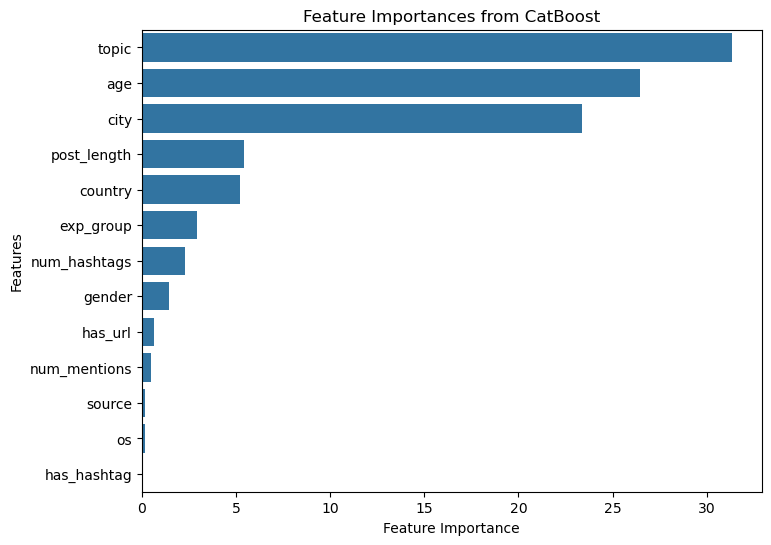

In [107]:
# DataFrame for plotting
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot
plt.figure(figsize=(8, 6))
sns.barplot(data=importance_df, x='Importance', y='Feature', orient='h')
plt.title('Feature Importances from CatBoost')
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.show()

In [109]:
catboost.save_model('catboost_model_3.cbm',
                           format="cbm")

from_file = CatBoostClassifier()  # здесь не указываем параметры, которые были при обучении, в дампе модели все есть

from_file.load_model("catboost_model_3.cbm")

from_file.predict(X_train)

array([0, 0, 0, ..., 0, 0, 0])

In [111]:
import os
from catboost import CatBoostClassifier

def get_model_path(path: str) -> str:
    if os.environ.get("IS_LMS") == "1":  # проверяем где выполняется код в лмс, или локально. Немного магии
        MODEL_PATH = '/workdir/user_input/model'
    else:
        MODEL_PATH = path
    return MODEL_PATH


def load_models():
    model_path = get_model_path("/Users/daraluzina/ML/HW_22/Ver_1.0/catboost_model_3.cbm")  
    
    # Load CatBoost model
    model = CatBoostClassifier()
    model.load_model(model_path)
    
    return model

In [113]:
model_test = load_models()

In [115]:
model_test.predict(X_train)

array([0, 0, 0, ..., 0, 0, 0])